# TuLiP Example: Animal Herding

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import networkx as nx

from tulip import transys, spec, synth, dumpsmach, gridworld

## Construct a gridworld for the robot

/home/petter/.venvs/tulip/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:520: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/petter/.venvs/tulip/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:541: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/petter/.venvs/tulip/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:722: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


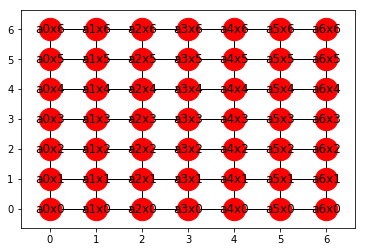

In [2]:
W = 7   # with of gridworld
H = 7   # height of gridworld

fts = transys.FTS()

# add nodes (state set X)
fts.add_nodes_from('a{}x{}'.format(i,j) for i in range(W) for j in range(H))

# add actions (input set U)
fts.sys_actions.add_from(['north', 'west', 'south', 'east'])

# add transitions
for i in range(W):
    for j in range(H):
        fts.add_edge( 'a{}x{}'.format(i,j), 'a{}x{}'.format(i,min(H-1,j+1)), sys_actions='north')
        fts.add_edge( 'a{}x{}'.format(i,j), 'a{}x{}'.format(i,max(0,  j-1)), sys_actions='south')
        fts.add_edge( 'a{}x{}'.format(i,j), 'a{}x{}'.format(min(W-1, i+1),j), sys_actions='east')
        fts.add_edge( 'a{}x{}'.format(i,j), 'a{}x{}'.format(max(0,   i-1),j), sys_actions='west')

# draw with networkx
pos = dict()
for i in range(W):
    for j in range(H):
        pos['a{}x{}'.format(i,j)] = (i,j)
        
nx.draw_networkx(fts, with_labels=True, arrows=True, node_size=500, pos = pos)

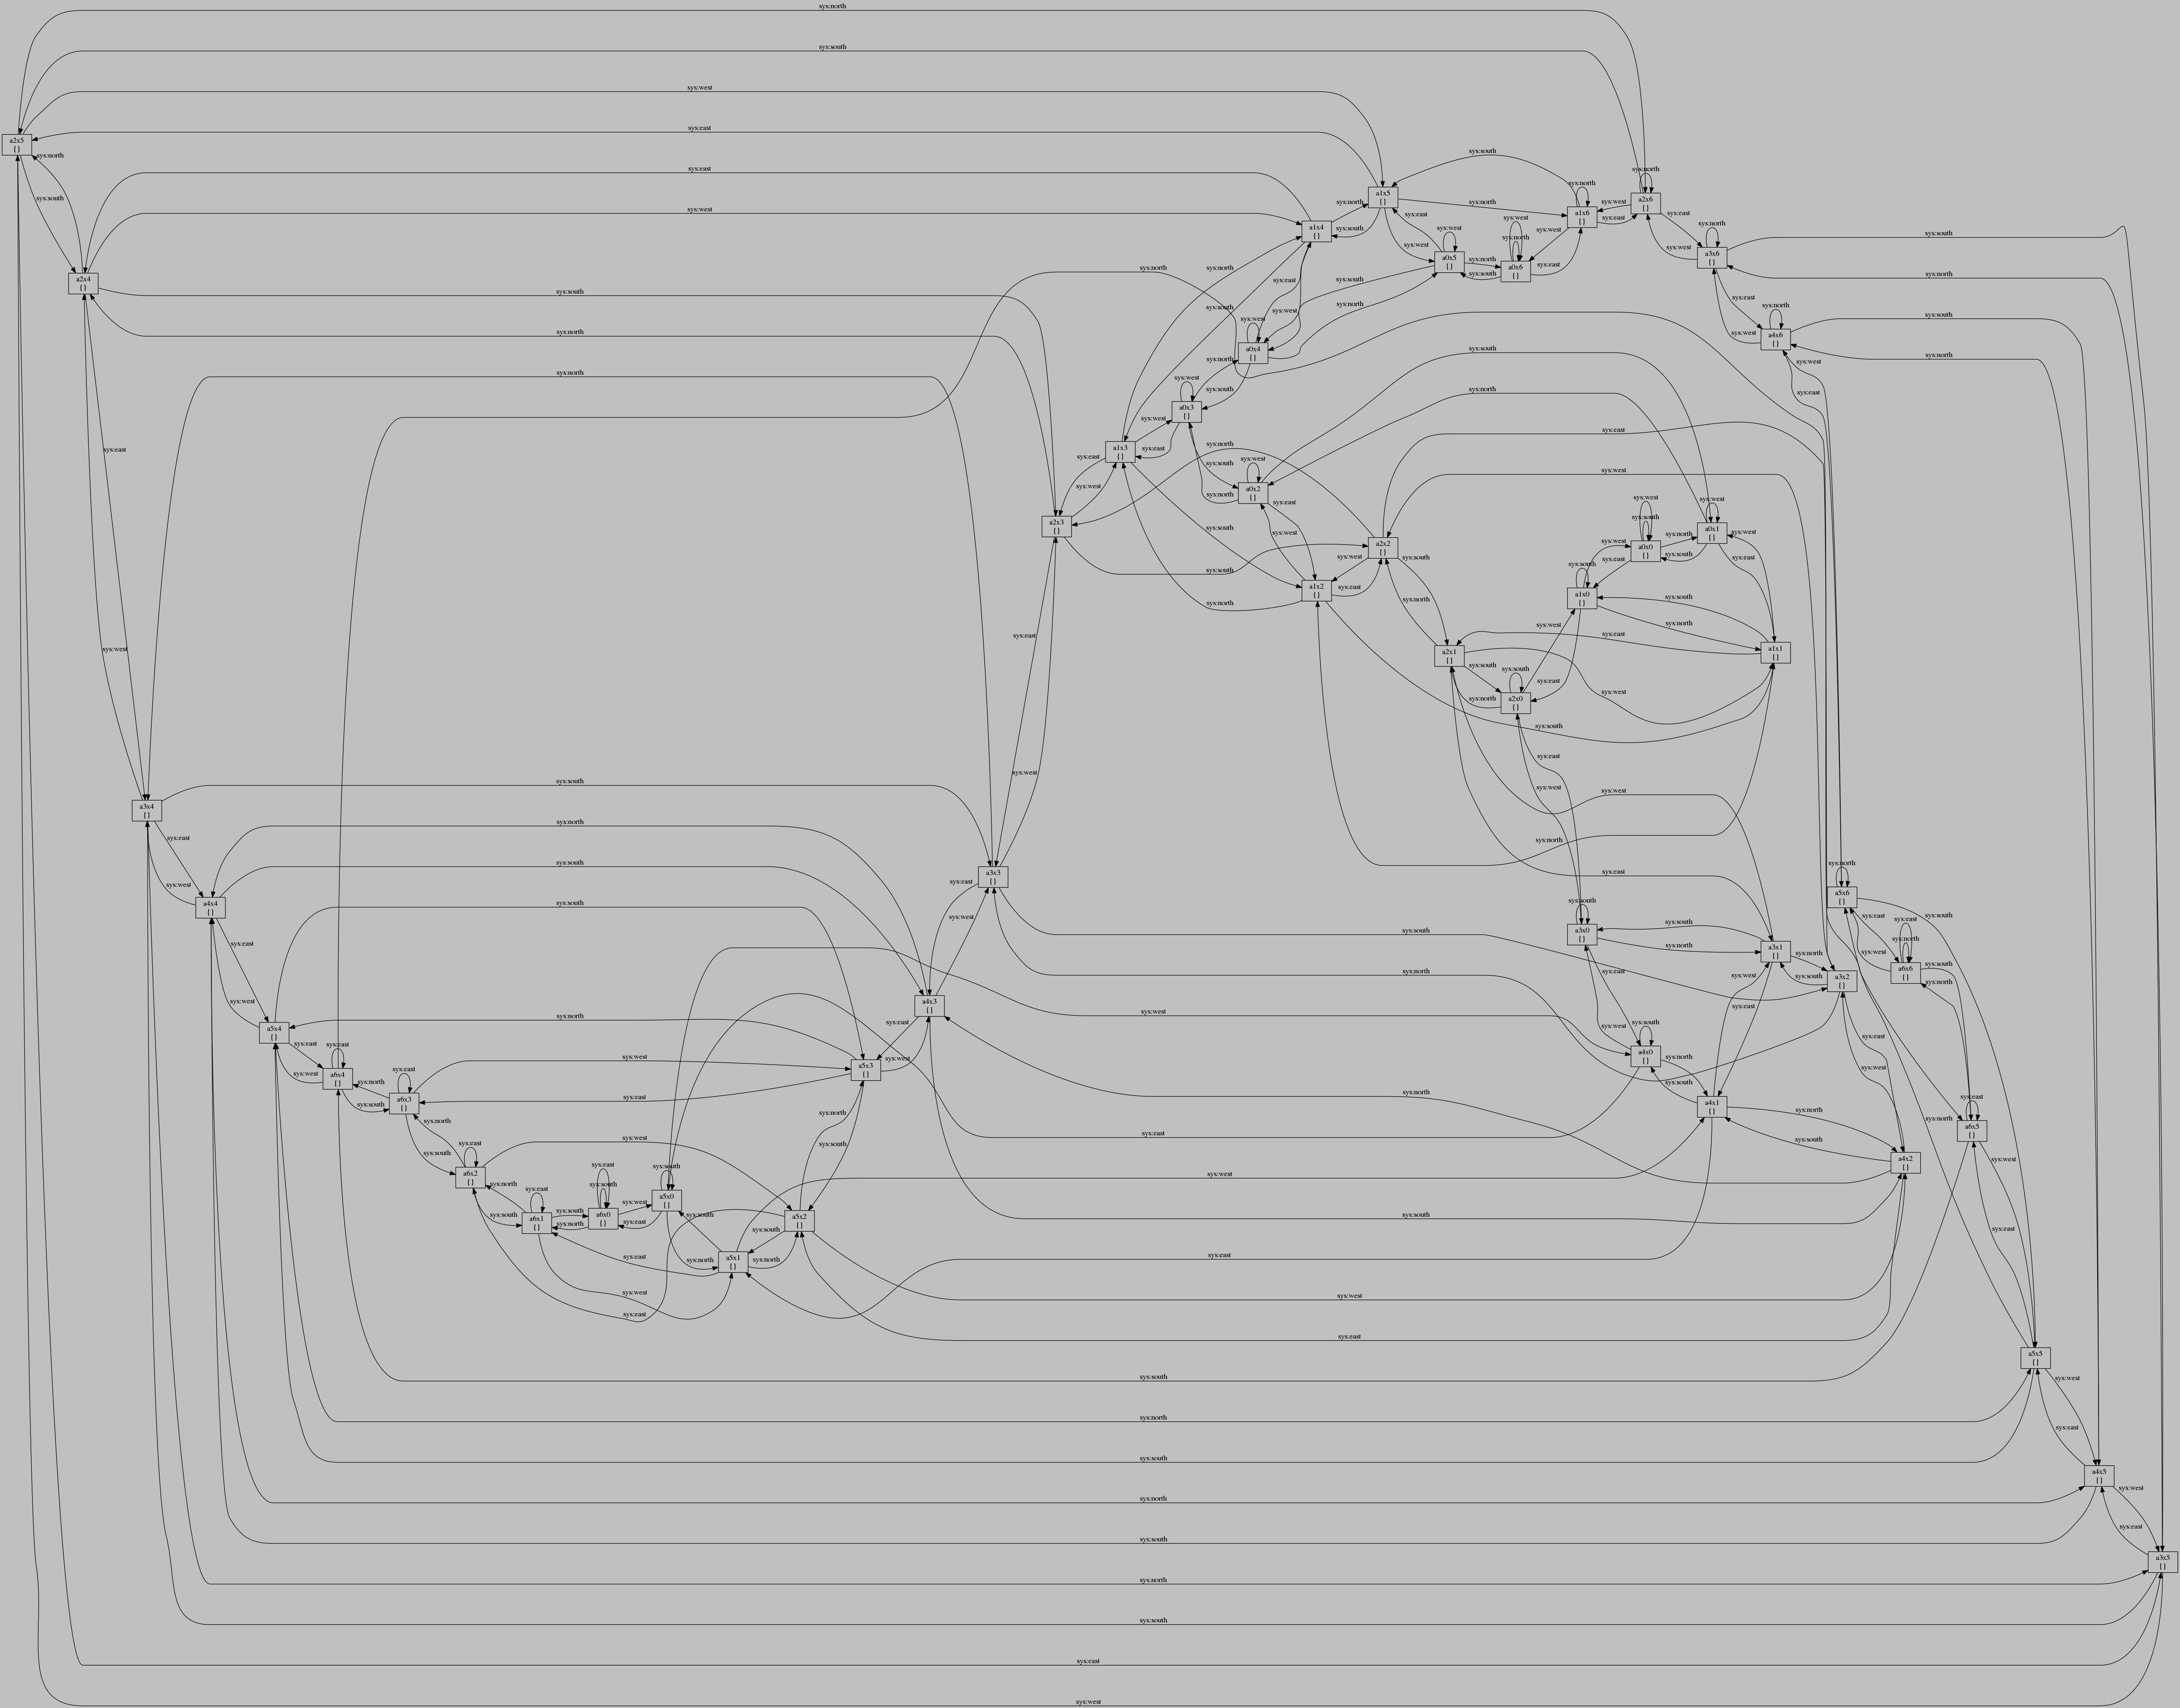

True

In [3]:
# draw with tulip
fts.plot()

## Define atomic propositions and specification

In [4]:
# Add atomic propositions
fts.atomic_propositions |= {'blocked', 'cat_target', 'mouse_target', 'dog_target'}

# define blocked states
blocked_list = ['a0x1', 'a0x6', 'a1x4', 'a2x1', 'a2x3', 'a3x3', \
                'a3x6', 'a4x0', 'a4x5', 'a4x6', 'a5x5', 'a5x6', \
                'a6x3', 'a6x6']
    
for state in blocked_list:
    fts.node[state]['ap'] |= {'blocked'}

fts.node['a6x0']['ap'] |= {'cat_target'}
fts.node['a6x5']['ap'] |= {'mouse_target'}
fts.node['a0x0']['ap'] |= {'dog_target'}

for state in fts.states():
    if state not in blocked_list:
        fts.states.initial.add(state)


# Formula variables
env_vars = {'dog', 'cat', 'mouse'}
sys_vars = {'bone', 'yarn', 'flute'}

# Intitialize and requirements
env_safe = set()
sys_safe = set()
sys_prog = set()

# Don't visit blocked regions
sys_safe |= {'! blocked'}

if True:

    # PETTER REQUIREMENTS

    # Can't herd (dog and cat) or (cat and mouse)
    sys_safe |= {'! ( bone && yarn  )'}
    sys_safe |= {'! ( yarn && flute  )'}
    
    # A. Add some targets to surveil
    sys_prog |= {'eloc = "a0x2"', 'eloc = "a4x4"', 'eloc = "a5x0"', 'eloc = "a3x0"'}

    # B. If herding, eventually reach target
    sys_prog |= {'dog_target || ! bone'}
    sys_prog |= {'cat_target || ! yarn'} 
    sys_prog |= {'mouse_target || ! flute'}

    # C. If no dog, dont show bone, etc
    sys_safe |= {'(! dog) -> (! bone)'}
    sys_safe |= {'(! mouse) -> (! flute)'}
    sys_safe |= {'(! cat) -> (! yarn)'}

    # D. Herd at least one if sensing
    sys_safe |= {'( dog || cat || mouse ) -> ( bone || yarn || flute )'}

    # EXTRA: prioritize mouse over cat
    # sys_safe |= {'(!dog && cat && mouse) -> flute'}

else: 

    ### KRESS-GAZIT' REQUIREMENTS

    # Problem 1: no mandate to herd mouse
    # Problem 2: 4 (can't herd) vs 8 (herd)

    
    # No mouse in a3x4 unless herded there
    # env_safe |= {'! ( ! (flute && mouse) && (X eloc = "a3x4") && X mouse )'}
    # env_safe |= {'! ( ! (yarn && cat) && (X eloc = "a2x2") && X cat )'}
    
    # A. Add some targets to surveil
    sys_prog |= {'eloc = "a0x2"', 'eloc = "a4x4"', 'eloc = "a5x0"', 'eloc = "a3x0"'}

    # B. If herding, eventually reach target
    sys_prog |= {'dog_target || ! bone'}
    sys_prog |= {'cat_target || ! yarn'} 
    sys_prog |= {'mouse_target || ! flute'}


    # 1. Can not herd dog and cat (OK)
    sys_safe |= {'! ( bone && yarn  )'}

    # 2. Can not herd cat and mouse
    sys_safe |= {'! ( yarn && flute  )'}

    # 3. Must herd at least one animal if there is one (OK)
    sys_safe |= {'( dog || cat || mouse ) -> ( bone || yarn || flute )'}

    # 4. Not herd cat through no_cats
#     sys_safe |= {'yarn -> (eloc != "a2x0" && eloc != "a2x2")'}

    # 5. Not herd mouse through no_mouse (OK)
    sys_safe |= {'flute -> (eloc != "a3x4")'}

    # 6. If sense dog, must start herding it unless herding cat (OK)
    sys_safe |= {'( X dog && ( ! ( yarn && X cat ) ) ) -> X bone'}

    # 7. When sensing dog and cat, herd dog
    sys_safe |= {'( dog && cat && ! mouse ) -> bone'}

    # 8. When sensing cat and mouse, herd cat (conflict with 4)
    sys_safe |= {'( cat && mouse && ! dog ) -> yarn'}

    # 9. When sensing cat must start herding it, unless herding mouse or sensing dog
    sys_safe |= {'( ( X cat && (! ( flute && X mouse ) ) && ! X dog ) ) -> X yarn'}

    # 10. Is it B? ???
    
    # EXTRA: If only sensing mouse, herd it (conflict with 5)
    sys_safe |= {'(mouse && ! dog && ! cat) -> flute'}
    
formula = spec.GRSpec(env_vars=env_vars, 
                      sys_vars=sys_vars,
                      env_safety=env_safe,
                      sys_safety=sys_safe,
                      sys_prog=sys_prog)

print(formula.pretty())

ENVIRONMENT VARIABLES:
	mouse	boolean
	dog	boolean
	cat	boolean

SYSTEM VARIABLES:
	flute	boolean
	bone	boolean
	yarn	boolean

FORMULA:
ASSUMPTION:
GUARANTEE:
    SAFETY
	  [](! ( bone && yarn  ))
	& []((! cat) -> (! yarn))
	& [](! ( yarn && flute  ))
	& [](( dog || cat || mouse ) -> ( bone || yarn || flute ))
	& [](! blocked)
	& []((! dog) -> (! bone))
	& []((! mouse) -> (! flute))
    LIVENESS
	  []<>(eloc = "a5x0")
	& []<>(eloc = "a4x4")
	& []<>(mouse_target || ! flute)
	& []<>(dog_target || ! bone)
	& []<>(eloc = "a3x0")
	& []<>(cat_target || ! yarn)
	& []<>(eloc = "a0x2")



## Solve synthesis problem

In [5]:
# Set formula parameters
formula.moore = False     # can see next env state
formula.qinit = '\A \E'   # solve s.t. for all (\A) env initial conditions there exists (\E) sys initial condition 

fts.owner = 'env'

# Print complete spec (sys + spec)
# print synth._spec_plus_sys(formula, fts, None, False, False).pretty()

ctrl = synth.synthesize('omega', formula, env=fts)

dumpsmach.write_python_case("herding_policy.py", ctrl, classname="HerdingPolicy")

removed 0 nodes from 1162 total


## Simulation

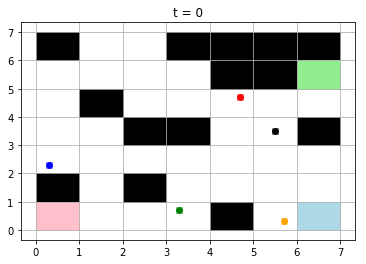

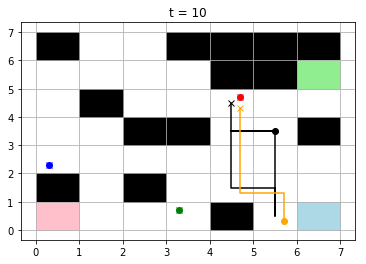

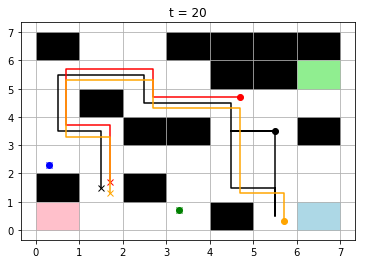

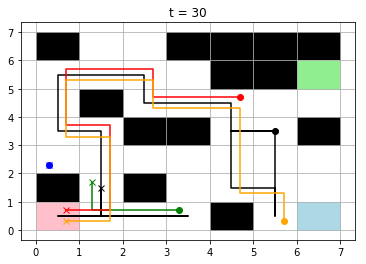

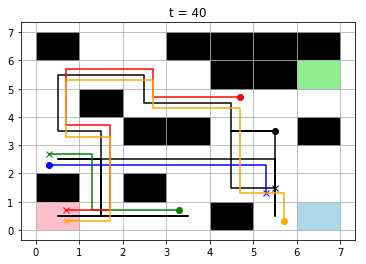

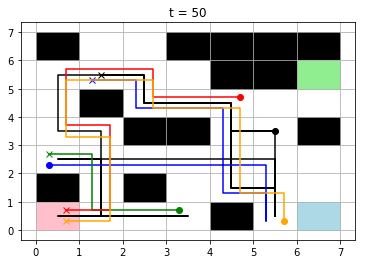

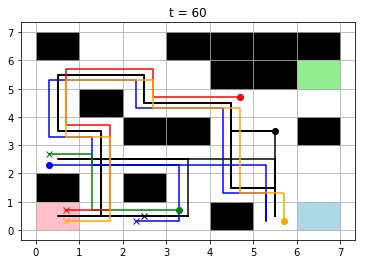

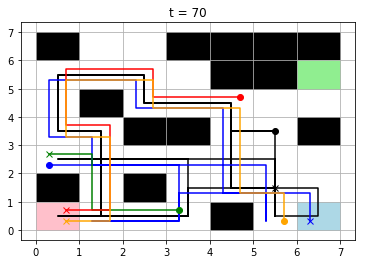

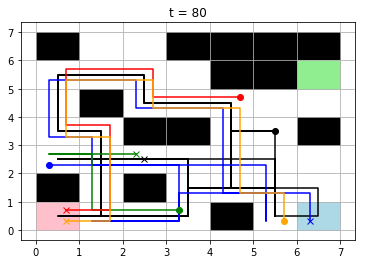

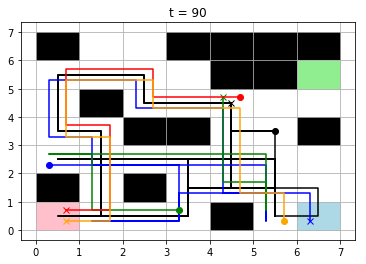

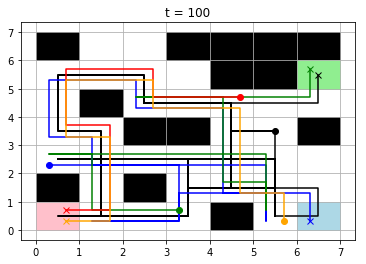

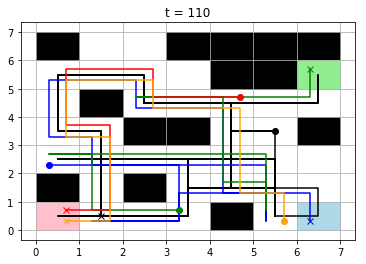

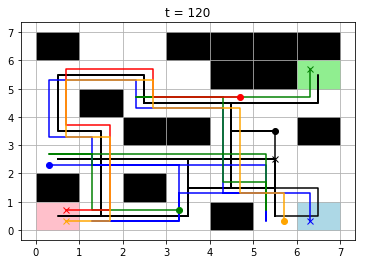

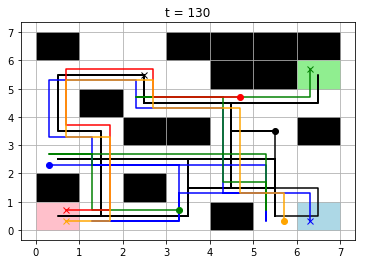

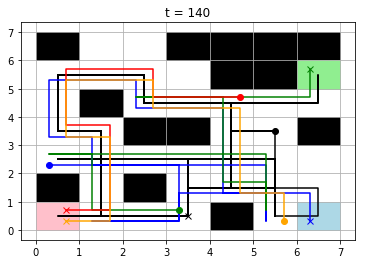

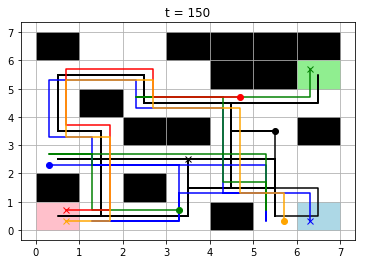

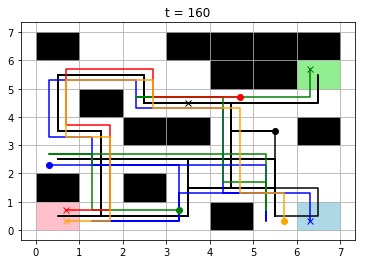

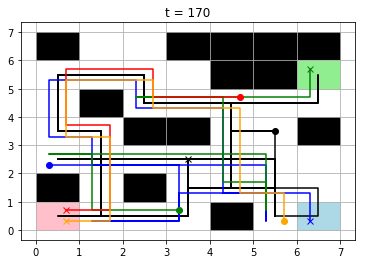

In [6]:
from herding_policy import HerdingPolicy
from simulate_herding import simulate

h = HerdingPolicy()
simulate(h, fts)